In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import mapclassify
import geopandas as gpd
import pandas as pd
from _bootstrap import *
from community_detection import (
    GraphConstructor,
    CommunityDetector,
    PolygonDissolver)
from paths import get_paths
input_dir, output_dir, plots_dir = get_paths()

In [2]:
# Set target pop
target_pop = 300

matrix = pd.read_parquet(output_dir / "matrices.parquet")

# Select matrix and Tracts
matrix = matrix.loc[matrix["target_pop"]==target_pop].copy()

tracts = gpd.read_file(output_dir / "tracts.gpkg", layer=f"tracts_{target_pop}")
tracts["TractID"] = tracts["TractID"].astype(str)

gc = GraphConstructor(matrix, weights_col="visit_share")
gc.build_graph()
G = gc.get_graph()

In [3]:
# Run the best configuration
cd = CommunityDetector(G, tracts, trials=30)
result, score, time = cd.run_infomap(return_codelength=True, preferred_modules=39, measure_time=True,
                                     enforce_spatial=True, strategy="strongest_connection", verbose=False)

df = pd.DataFrame(result.items(), columns=["TractID", "community"])

li = cd.compute_localisation_index(result, matrix, weight_col="n_visits")
li.LI.describe()

count    39.000000
mean      0.674343
std       0.114487
min       0.380636
25%       0.615903
50%       0.708494
75%       0.759127
max       0.824763
Name: LI, dtype: float64

In [4]:
# Create the PCSAs
tracts["TractID"] = tracts["TractID"].astype(str)
polygon_dissolver = PolygonDissolver(tracts)
pcsa = polygon_dissolver.process_community_outcomes(communities=df, verbose=False)

# Add Localisation Index with flow values
pcsa = pcsa.merge(li, on="community", how="left")
pcsa.head()

,commune_id,commune,community,pop,pop_high,pop_middle,pop_low,geometry,D_c,D_cc,LI
0,13201,PUENTE ALTO,1,69289,4133,31468,33688,"POLYGON ((353161.607 6279278.010, 353152.333 6...",245583,173994,0.708494
1,13201,PUENTE ALTO,2,87752,9438,49472,28842,"POLYGON ((353844.494 6281988.798, 353839.116 6...",246838,165568,0.670756
2,13110,LA FLORIDA,3,44211,1172,16740,26299,"POLYGON ((350352.737 6284165.231, 350352.065 6...",204665,155563,0.760086
3,13201,PUENTE ALTO,4,51153,1481,18304,31368,"POLYGON ((351588.900 6277190.600, 351588.714 6...",271894,219641,0.807818
4,13201,PUENTE ALTO,5,53291,2335,24237,26719,"POLYGON ((350843.602 6281765.156, 350843.595 6...",222367,158809,0.714175


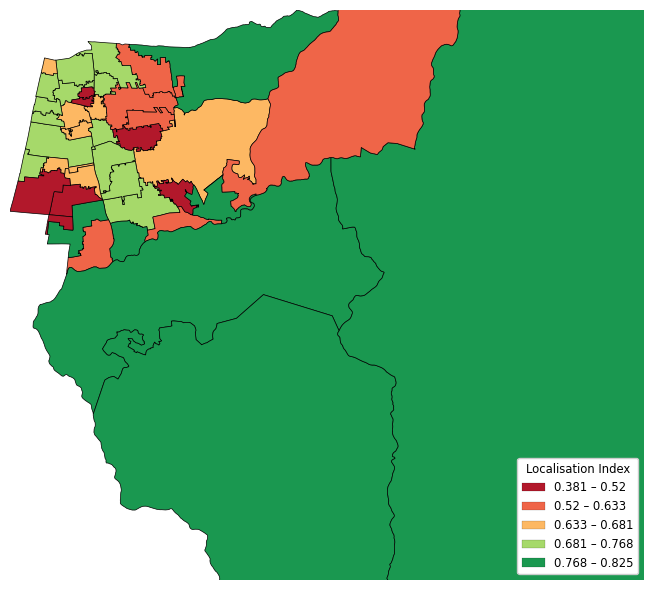

In [5]:
#Classify using Natural Breaks (Jenks)
nb = mapclassify.NaturalBreaks(y=pcsa["LI"], k=5)
pcsa["LI_class"] = nb.yb  # class indices (0 to 4)

# Create numeric range labels for legend
bin_labels = [f"{round(b, 3)} – {round(nb.bins[i], 3)}" for i, b in enumerate([pcsa["LI"].min()] + list(nb.bins[:-1]))]

# Assign a color to each bin
color_list = ['#b2182b', '#ef6548', '#fdb863', '#a6d96a', '#1a9850']
color_dict = {i: color_list[i] for i in range(5)}

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
pcsa.plot(
    color=pcsa["LI_class"].map(color_dict),
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

urban_comms = ['PUENTE ALTO', 'SAN RAMÓN', 'LA FLORIDA', 'LA PINTANA', 'LA GRANJA']
urban_pcsas = pcsa.loc[pcsa.commune.isin(urban_comms)]
minx, miny, maxx, maxy = urban_pcsas.total_bounds
ax.set_xlim(minx, maxx + 20000)
ax.set_ylim(miny - 20000, maxy)

ax.axis('off')

legend_handles = [
    Patch(facecolor=color_dict[i], edgecolor='black', linewidth=0.1, label=bin_labels[i])
    for i in range(5)
]
ax.legend(
    handles=legend_handles,
    title="Localisation Index",
    loc='lower right',
    fontsize='small',
    title_fontsize='small',
    framealpha=1
)

plt.tight_layout()
plt.savefig(plots_dir / "pcsa_LI.png", dpi=200, bbox_inches='tight')
plt.show()